<a href="https://colab.research.google.com/github/marwenmejri/ASL_Recognition_with_mediaipe_and_transfert_learning/blob/master/ASL_Recognition_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#liaison entre le Drive et le fichier colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from helper_functions import *

In [ ]:
unzip_data("/content/drive/MyDrive/ASL_Recognition_with_mediaipe_and_transfer_learning/archive.zip")

In [ ]:
import os 
print(os.listdir("/content/asl_alphabet_train/asl_alphabet_train"))
len(os.listdir("/content/asl_alphabet_train/asl_alphabet_train"))

['N', 'E', 'nothing', 'B', 'W', 'G', 'M', 'F', 'L', 'del', 'Q', 'A', 'P', 'I', 'Z', 'R', 'space', 'O', 'H', 'X', 'U', 'Y', 'C', 'V', 'J', 'S', 'D', 'T', 'K']


29

In [ ]:
from helper_functions import *
walk_through_dir("/content/asl_alphabet_train/asl_alphabet_train")

There are 29 directories and 0 images in '/content/asl_alphabet_train/asl_alphabet_train'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/N'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/E'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/nothing'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/B'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/W'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/G'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/M'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/F'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/L'.
There are 0 directories and 3000 images in '/con

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Create training and testing directories
# test_dir = "/content/asl_alphabet_test/asl_alphabet_test"
train_dir = "/content/asl_alphabet_train/asl_alphabet_train"

# Creating train and validation sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.2)

train_data = datagen.flow_from_directory(train_dir, subset='training',target_size=(200, 200))
val_data = datagen.flow_from_directory(train_dir, subset='validation', shuffle=False, target_size=(200, 200))

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
train_data.image_shape

(200, 200, 3)

In [ ]:
val_data.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [ ]:
class_names = list(val_data.class_indices.keys())
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [ ]:
### Model 0: Building a transfer learning model using the Keras Functional API

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(200, 200, 3), name="input_layer")

# 4. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)

# Check data shape after passing it to the base_model
print(f"Shape after base_model : {x.shape}")

# 5. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="Output_Layer")(x)

# 7. Combine the outputs and the inputs into a model
model_0 = tf.keras.models.Model(inputs=inputs, outputs=outputs)

Shape after base_model : (None, 6, 6, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
# 8. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Output_Layer (Dense)        (None, 29)                37149     
                                                                 
Total params: 4,086,720
Trainable params: 37,149
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer_num, layer in enumerate(model_0.layers):
  print(layer_num, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 Output_Layer


In [ ]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# 9. Fit the Model (we use less steps for validation so it's faster)
history_0 = model_0.fit(train_data,
                        epochs=2,
                        # steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=int(len(val_data)*0.25),
                        # # Track our model's training logs for visualization later
                        callbacks=[create_tensorboard_callback("transfer_learning", "ASL_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/ASL_feature_extraction/20211129-185526
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2175/2175 [==============================] - 2309s 1s/step - loss: 0.3521 - accuracy: 0.9437 - val_loss: 0.1303 - val_accuracy: 0.9809
Epoch 2/2
2175/2175 [==============================] - 2276s 1s/step - loss: 0.0593 - accuracy: 0.9922 - val_loss: 0.0665 - val_accuracy: 0.9862


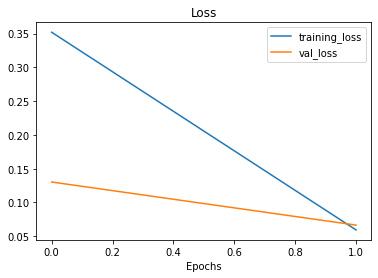

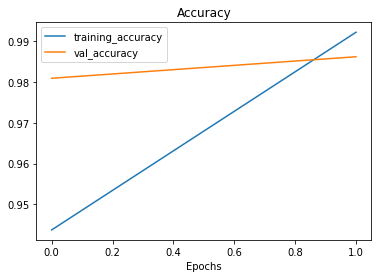

In [ ]:
plot_loss_curves(history_0)

In [ ]:
model_0 = tf.keras.models.load_model("/content/drive/MyDrive/ASL_Recognition_with_mediaipe_and_transfer_learning/SL_Model_Efficientnet.h5")

In [ ]:
results_0 = model_0.evaluate(val_data)

544/544 [==============================] - 536s 984ms/step - loss: 0.3400 - accuracy: 0.8920


In [ ]:
pred_probs = model_0.predict(val_data,verbose=1)

544/544 [==============================] - 78s 143ms/step


In [ ]:
# How many predictions are there?
len(pred_probs)

17400

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(17400, 29)

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[2470:2670]

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 17,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  4,  0])

In [ ]:
labels = val_data.labels

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(labels)

17400

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(labels, pred_classes)
sklearn_accuracy

0.848103448275862

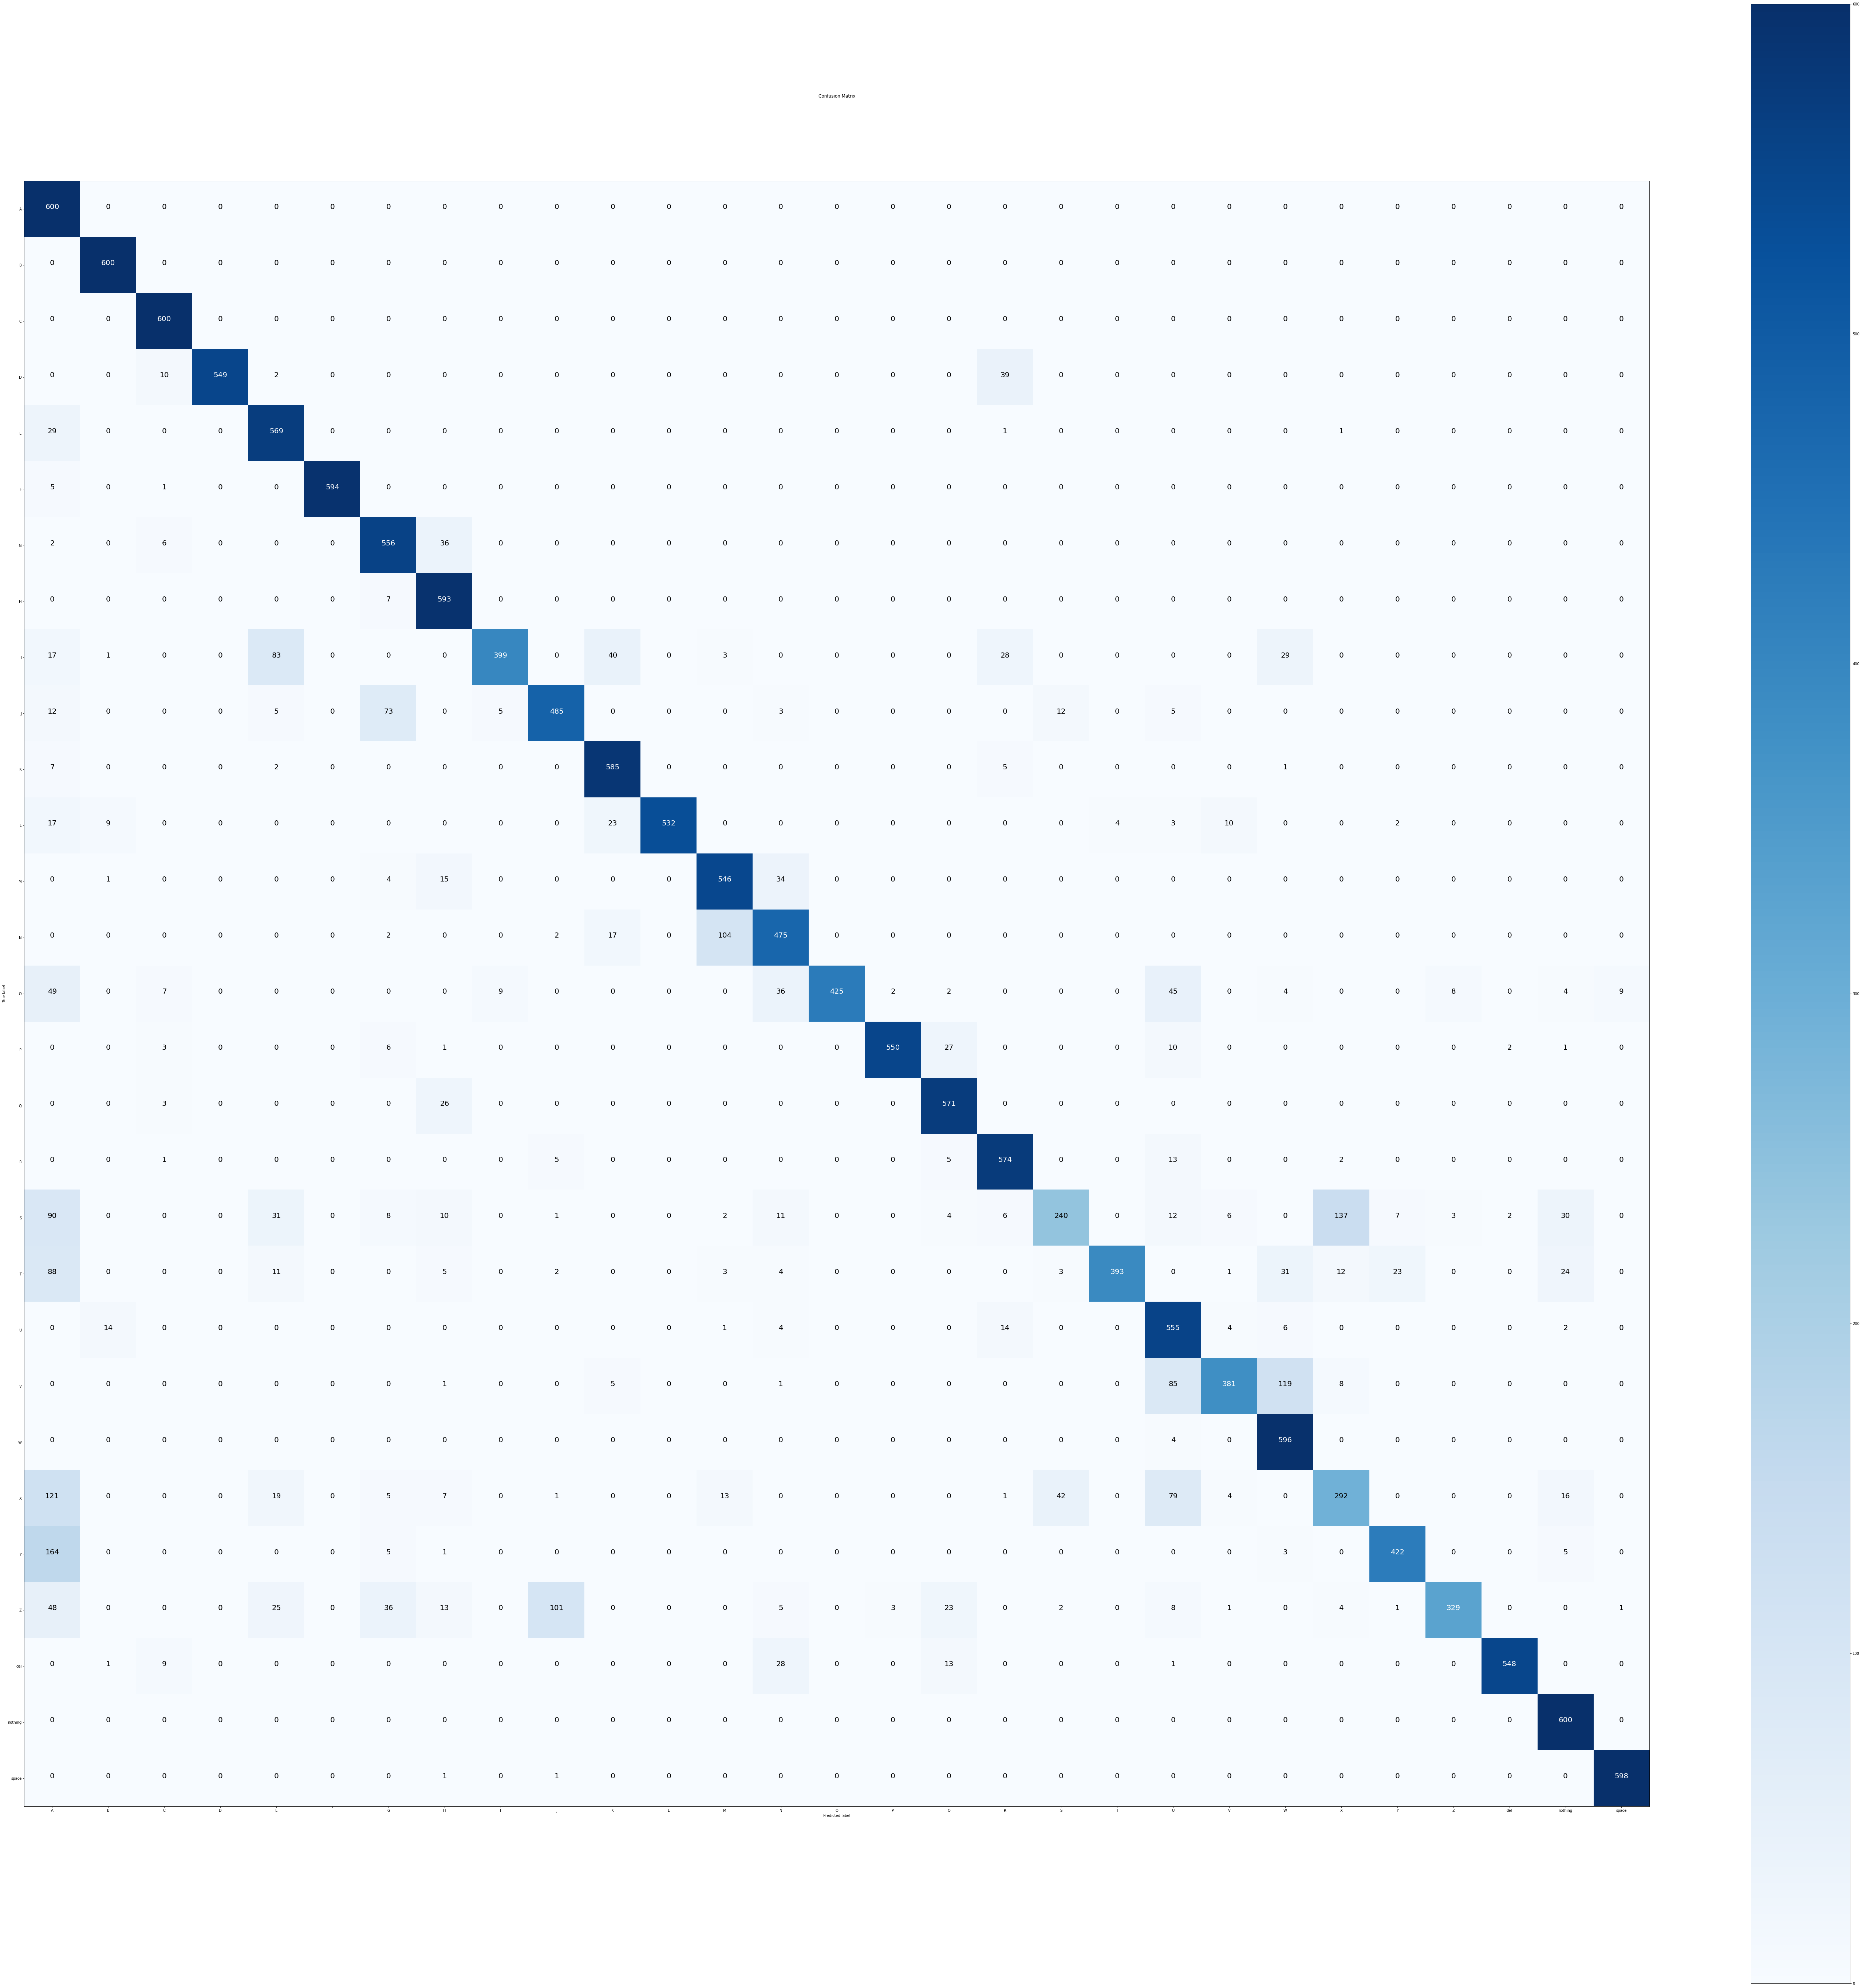

In [ ]:
# Plot a confusion matrix with all 17400 predictions, ground truth labels and 29 classes
make_confusion_matrix(y_true=labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       600
           1       0.96      1.00      0.98       600
           2       0.94      1.00      0.97       600
           3       1.00      0.92      0.96       600
           4       0.76      0.95      0.84       600
           5       1.00      0.99      0.99       600
           6       0.79      0.93      0.85       600
           7       0.84      0.99      0.91       600
           8       0.97      0.67      0.79       600
           9       0.81      0.81      0.81       600
          10       0.87      0.97      0.92       600
          11       1.00      0.89      0.94       600
          12       0.81      0.91      0.86       600
          13       0.79      0.79      0.79       600
          14       1.00      0.71      0.83       600
          15       0.99      0.92      0.95       600
          16       0.89      0.95      0.92       600
          17       0.86    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.6489994591671173,
  'precision': 0.4803843074459568,
  'recall': 1.0,
  'support': 600},
 '1': {'f1-score': 0.9787928221859706,
  'precision': 0.9584664536741214,
  'recall': 1.0,
  'support': 600},
 '10': {'f1-score': 0.921259842519685,
  'precision': 0.8731343283582089,
  'recall': 0.975,
  'support': 600},
 '11': {'f1-score': 0.9399293286219081,
  'precision': 1.0,
  'recall': 0.8866666666666667,
  'support': 600},
 '12': {'f1-score': 0.8584905660377358,
  'precision': 0.8125,
  'recall': 0.91,
  'support': 600},
 '13': {'f1-score': 0.7910074937552038,
  'precision': 0.7903494176372712,
  'recall': 0.7916666666666666,
  'support': 600},
 '14': {'f1-score': 0.8292682926829268,
  'precision': 1.0,
  'recall': 0.7083333333333334,
  'support': 600},
 '15': {'f1-score': 0.9523809523809523,
  'precision': 0.990990990990991,
  'recall': 0.9166666666666666,
  'support': 600},
 '16': {'f1-score': 0.9172690763052209,
  'precision': 0.8852713178294573,
  'recall': 0.951666

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'A': 0.6489994591671173,
 'B': 0.9787928221859706,
 'C': 0.967741935483871,
 'D': 0.9556135770234987,
 'E': 0.8448403860430587,
 'F': 0.9949748743718593,
 'G': 0.8540706605222734,
 'H': 0.906035141329259,
 'I': 0.7877591312931885,
 'J': 0.8096828046744574,
 'K': 0.921259842519685,
 'L': 0.9399293286219081,
 'M': 0.8584905660377358,
 'N': 0.7910074937552038,
 'O': 0.8292682926829268,
 'P': 0.9523809523809523,
 'Q': 0.9172690763052209,
 'R': 0.9053627760252365,
 'S': 0.5339265850945495,
 'T': 0.7883650952858576,
 'U': 0.7816901408450704,
 'V': 0.7567030784508441,
 'W': 0.8581713462922965,
 'X': 0.553030303030303,
 'Y': 0.8,
 'Z': 0.7,
 'del': 0.9513888888888888,
 'nothing': 0.9360374414976599,
 'space': 0.990066225165563}

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
5,F,0.994975
28,space,0.990066
1,B,0.978793
2,C,0.967742
3,D,0.955614
15,P,0.952381
26,del,0.951389
11,L,0.939929
27,nothing,0.936037
10,K,0.921260


Now we're talking! Let's finish it off with a nice horizontal bar chart.



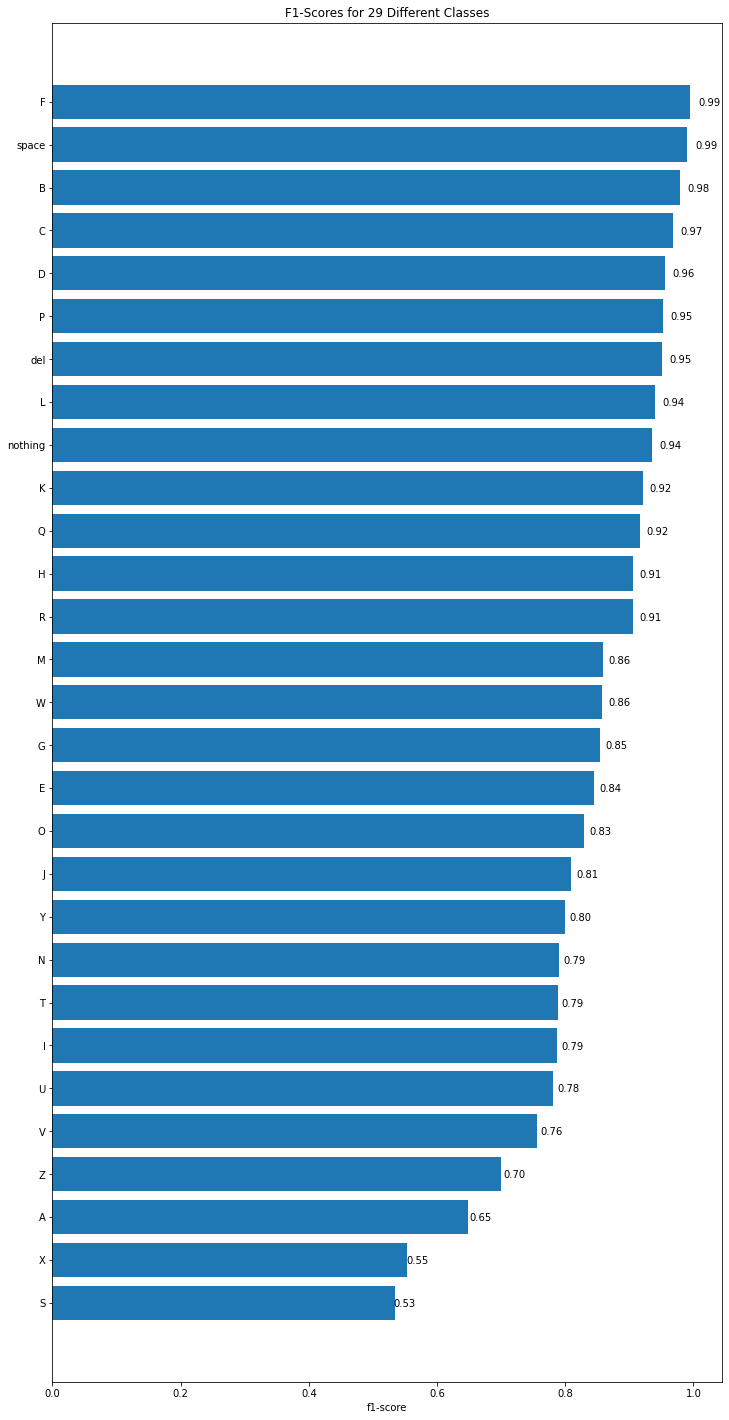

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 29 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def make_prediction(model, img, real_classname, input_shape, class_names):
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(f"Real: {real_classname}")
    plt.axis(False);
    image = cv2.resize(img, input_shape)

    img_reshaped = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    pred = model.predict(img_reshaped)

    if len(pred[0]) > 1:
        pred_class = class_names[pred[0].argmax()]  # if more than one output, take the max
    prob = np.round(np.max(pred[0]),2)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    return pred_class, prob

('A', 0.84)

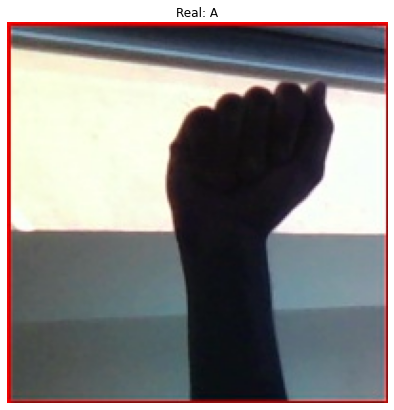

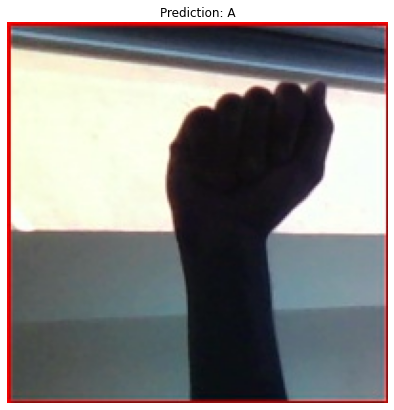

In [ ]:
A = cv2.imread("/content/asl_alphabet_test/asl_alphabet_test/A_test.jpg")
B = cv2.imread("/content/asl_alphabet_test/asl_alphabet_test/B_test.jpg")
C = cv2.imread("/content/asl_alphabet_test/asl_alphabet_test/C_test.jpg")
D = cv2.imread("/content/asl_alphabet_test/asl_alphabet_test/D_test.jpg")

make_prediction(model=model_0, img=A, real_classname='A', input_shape=(224, 224), class_names=class_names)

In [ ]:
pred

array([[8.35624754e-01, 3.21524169e-07, 2.37037803e-08, 1.07273799e-08,
        4.50511556e-03, 4.96103130e-05, 1.14336274e-07, 1.53318269e-09,
        2.12742452e-05, 4.23489325e-07, 4.63812366e-09, 7.01538667e-08,
        8.24466551e-05, 8.78246226e-07, 1.23489717e-05, 1.78675130e-09,
        9.42392608e-10, 1.61165414e-09, 1.59305826e-01, 2.71304307e-04,
        1.24084751e-08, 3.43236593e-06, 1.96371232e-07, 5.99042687e-05,
        6.17944024e-05, 4.75922306e-08, 3.81258509e-08, 8.19017909e-10,
        5.16972456e-08]], dtype=float32)

('B', array([[2.1918675e-11, 9.9970633e-01, 3.7013812e-08, 4.6605205e-08,
        7.2719216e-05, 9.1366248e-09, 1.7583706e-09, 4.9775526e-08,
        3.8932271e-06, 8.3170555e-09, 1.7631471e-08, 1.3106181e-10,
        6.3240128e-07, 1.0464383e-09, 3.2096267e-08, 2.6497409e-07,
        2.8360456e-10, 8.6772110e-07, 5.0770232e-08, 5.6650146e-07,
        2.1205036e-04, 2.1118534e-08, 1.3022819e-08, 2.2489744e-06,
        1.6312587e-10, 1.8669943e-09, 1.1882060e-09, 1.4623721e-12,
        3.0328149e-08]], dtype=float32))


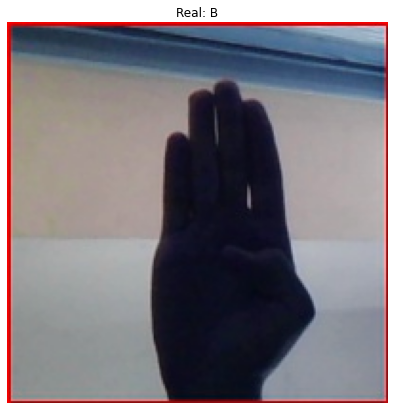

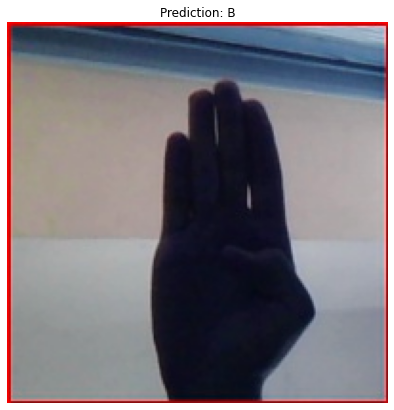

In [ ]:
print(make_prediction(model=model_0, img=B, real_classname='B', input_shape=(224, 224), class_names=class_names))

('D', array([[6.1617356e-10, 8.6191511e-07, 2.3363051e-03, 9.7800612e-01,
        3.6917532e-07, 1.7525913e-02, 1.8609051e-05, 1.5953751e-06,
        1.5583717e-05, 5.6100789e-06, 6.7691086e-05, 1.4197506e-04,
        2.2774465e-09, 2.3370453e-10, 5.0930312e-04, 8.2501327e-05,
        2.4656066e-07, 3.7560530e-05, 4.0730490e-09, 2.4577162e-07,
        1.5620690e-05, 6.0469646e-04, 7.9589455e-09, 8.2592793e-05,
        2.3983406e-04, 9.5954613e-07, 6.5877011e-08, 1.8835731e-09,
        3.0571510e-04]], dtype=float32))


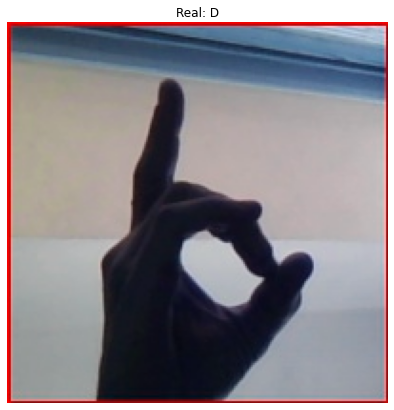

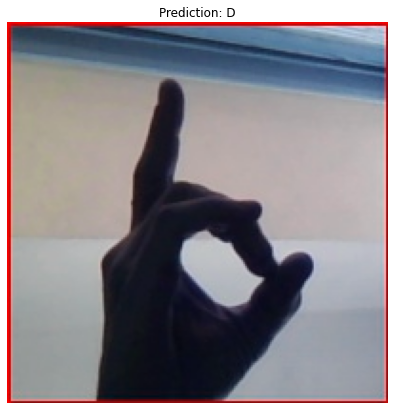

In [ ]:
print(make_prediction(model=model_0, img=D, real_classname='D', input_shape=(224, 224), class_names=class_names))

In [ ]:
# Save a model
model_0.save("SL_Model_Efficientnet.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
len(os.listdir("/content/asl_alphabet_test/asl_alphabet_test"))

28

In [ ]:
test_data = []
y_true = []
for x in os.listdir("/content/asl_alphabet_test/asl_alphabet_test"):
  img = cv2.imread(os.path.join("/content/asl_alphabet_test/asl_alphabet_test",x))
  img = cv2.resize(img, (224, 224))
  test_data.append(img)
  y_true.append(x.split("_")[0])

In [ ]:
y_true

['G',
 'B',
 'D',
 'W',
 'U',
 'Y',
 'L',
 'M',
 'A',
 'Z',
 'F',
 'P',
 'space',
 'H',
 'Q',
 'K',
 'O',
 'J',
 'I',
 'C',
 'T',
 'X',
 'nothing',
 'R',
 'V',
 'N',
 'E',
 'S']

In [ ]:
test_data = np.array(test_data)
test_data.shape

(28, 224, 224, 3)

In [ ]:
train_data.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [ ]:
test_labels = []
for label in y_true:
  y = val_data.class_indices[label]
  test_labels.append(y)
test_labels

[6,
 1,
 3,
 22,
 20,
 24,
 11,
 12,
 0,
 25,
 5,
 15,
 28,
 7,
 16,
 10,
 14,
 9,
 8,
 2,
 19,
 23,
 27,
 17,
 21,
 13,
 4,
 18]

In [ ]:
pred_probs_test = model_0.predict(test_data)
pred_probs_test.shape

(28, 29)

In [ ]:
pred_probs_test[0]

array([4.0075048e-12, 3.6817660e-09, 2.0253423e-04, 2.5337224e-07,
       1.0231864e-11, 1.8760539e-07, 9.9694997e-01, 7.5911172e-04,
       1.3065715e-09, 1.9161581e-03, 8.2169872e-06, 2.0141263e-06,
       4.5704293e-10, 1.6750629e-08, 5.9623739e-10, 1.1822362e-04,
       7.5753833e-06, 5.2517450e-08, 1.5485039e-11, 3.8678820e-07,
       5.2254241e-09, 2.2898712e-08, 1.5603284e-10, 7.2849595e-08,
       8.2224636e-07, 2.4942316e-05, 5.7352441e-08, 1.4058264e-10,
       9.4642000e-06], dtype=float32)

In [ ]:
pred_classes_test = pred_probs_test.argmax(axis=1)
pred_classes_test, len(pred_classes_test), len(test_labels)

(array([ 6,  1,  3, 22, 20, 24, 11, 12,  0, 25,  5, 15, 28,  7, 16, 10, 14,
         9,  8,  2, 19, 23, 27, 17, 21, 13,  4, 18]), 28, 28)

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(test_labels, pred_classes_test)
sklearn_accuracy

1.0

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_classes_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

# **MediaPipe Model** 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score # Accuracy metrics

df = pd.read_csv('/content/drive/MyDrive/ASL_Recognition_with_mediaipe_and_transfer_learning/coords.csv')

In [ ]:
df.shape

(2588, 64)

In [ ]:
df.head(5)

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16,x17,y17,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,B,0.363851,0.961750,-0.000345,0.253697,0.889724,-0.119312,0.199199,0.772660,-0.222685,0.240737,0.655995,-0.310137,0.329058,0.587110,-0.379452,0.215709,0.554637,-0.162754,0.193126,0.372672,-0.215856,0.188901,0.254588,-0.257260,0.181150,0.145127,-0.293054,0.280826,0.529758,-0.145536,0.272250,0.325599,-0.212312,0.268006,0.196933,-0.262155,0.258906,0.078996,-0.293576,0.339647,0.543128,-0.125397,0.334547,0.351845,-0.171359,0.332554,0.235639,-0.206700,0.319116,0.129016,-0.219900,0.398205,0.585442,-0.117826,0.399488,0.441395,-0.154528,0.399601,0.350409,-0.178252,0.398052,0.269486,-0.187889
1,B,0.398418,0.966585,-0.000253,0.264814,0.930031,-0.162418,0.178322,0.822034,-0.258794,0.181428,0.699708,-0.328471,0.248409,0.624747,-0.380687,0.188014,0.598487,-0.169826,0.163513,0.410806,-0.230145,0.154772,0.287685,-0.278029,0.151587,0.178652,-0.316988,0.255646,0.561123,-0.129083,0.224296,0.348743,-0.180099,0.211138,0.215321,-0.228491,0.204272,0.090998,-0.264064,0.320993,0.558641,-0.093458,0.295017,0.361600,-0.136551,0.282358,0.245817,-0.163952,0.270699,0.141341,-0.173751,0.392303,0.581988,-0.073574,0.381252,0.433708,-0.107051,0.373309,0.340380,-0.117350,0.365921,0.256890,-0.119947
2,B,0.345987,0.979220,-0.000243,0.255445,0.873081,-0.044850,0.202996,0.758120,-0.113531,0.200605,0.658933,-0.186272,0.236044,0.597197,-0.253611,0.218382,0.567587,-0.087335,0.190068,0.390009,-0.147252,0.176213,0.268703,-0.198584,0.164538,0.162212,-0.239537,0.247259,0.564337,-0.118554,0.222996,0.357569,-0.191302,0.207020,0.224013,-0.253538,0.189951,0.101362,-0.300880,0.274130,0.597776,-0.147522,0.259176,0.403690,-0.215665,0.251552,0.286229,-0.258477,0.242758,0.175263,-0.278075,0.306995,0.658270,-0.181334,0.301274,0.515494,-0.246264,0.306882,0.434304,-0.281247,0.315175,0.357597,-0.303113
3,B,0.390517,0.964273,-0.000210,0.245408,0.914889,-0.120748,0.153243,0.805252,-0.204366,0.167786,0.673736,-0.277185,0.239539,0.590932,-0.339803,0.156273,0.594670,-0.099186,0.133593,0.405881,-0.144948,0.125978,0.281028,-0.180113,0.118852,0.176713,-0.206633,0.235220,0.567748,-0.089925,0.201109,0.352149,-0.132644,0.183423,0.218037,-0.181484,0.165952,0.098451,-0.218349,0.311047,0.572763,-0.088982,0.276206,0.373327,-0.130975,0.260138,0.257518,-0.175029,0.243399,0.150158,-0.198284,0.390349,0.603069,-0.099639,0.373433,0.449047,-0.152074,0.359471,0.357215,-0.186060,0.343237,0.269716,-0.206379
4,B,0.403994,0.964675,-0.000166,0.244454,0.916433,-0.102204,0.156273,0.803326,-0.181002,0.166209,0.673770,-0.254038,0.242320,0.599965,-0.311868,0.171109,0.593055,-0.075500,0.137288,0.407559,-0.129352,0.128524,0.280145,-0.175889,0.124645,0.170769,-0.209969,0.243716,0.562822,-0.070102,0.207628,0.351953,-0.123735,0.190393,0.217538,-0.176908,0.173179,0.094199,-0.212488,0.309007,0.567322,-0.069709,0.273823,0.363542,-0.111779,0.255138,0.246603,-0.142206,0.237986,0.135067,-0.154902,0.378950,0.597943,-0.082536,0.351569,0.443905,-0.119722,0.337045,0.353441,-0.138761,0.325870,0.266091,-0.145151


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,x5,y5,z5,x6,y6,z6,x7,y7,z7,x8,y8,z8,x9,y9,z9,x10,y10,z10,x11,y11,z11,x12,y12,z12,x13,y13,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16,x17,y17,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
431,B,0.428625,0.777466,-0.000207,0.348845,0.733133,-0.086388,0.314705,0.631972,-0.106316,0.343820,0.543062,-0.107291,0.382266,0.515501,-0.093655,0.328292,0.526065,-0.068699,0.304099,0.413672,-0.094098,0.293138,0.338172,-0.111044,0.288789,0.269999,-0.132754,0.376561,0.506717,-0.036004,0.347167,0.378741,-0.049201,0.331396,0.289279,-0.070078,0.323409,0.210890,-0.083535,0.419526,0.505587,-0.010115,0.398097,0.384780,-0.016183,0.383139,0.305472,-0.036792,0.376344,0.239422,-0.048794,0.463757,0.520732,0.006450,0.447721,0.425566,-0.007065,0.433183,0.363508,-0.023397,0.422845,0.309762,-0.032639
415,B,0.461601,0.772898,-0.000212,0.385278,0.731999,-0.104151,0.351335,0.634018,-0.131917,0.384565,0.545188,-0.137319,0.427463,0.509930,-0.126618,0.356998,0.524694,-0.068060,0.335314,0.414180,-0.094405,0.325060,0.339697,-0.112535,0.319541,0.274820,-0.133270,0.406638,0.505132,-0.030219,0.380465,0.381818,-0.041464,0.365010,0.296285,-0.060632,0.354298,0.221334,-0.072961,0.450773,0.505103,-0.002505,0.433436,0.390561,-0.011820,0.419140,0.316415,-0.035937,0.411696,0.253316,-0.049426,0.494729,0.522200,0.014007,0.480489,0.432860,-0.006036,0.465992,0.372638,-0.026788,0.454797,0.319132,-0.038735
768,E,0.398062,0.942510,-0.000291,0.295386,0.836398,-0.094136,0.269713,0.680173,-0.111995,0.382564,0.566397,-0.112650,0.509578,0.537656,-0.067056,0.296549,0.509890,0.069470,0.287714,0.337550,0.034423,0.302990,0.382965,-0.026849,0.316696,0.471399,-0.076022,0.380498,0.496364,0.082902,0.378534,0.297256,0.048119,0.381519,0.348581,-0.029253,0.378022,0.448956,-0.050732,0.455807,0.513996,0.078073,0.470698,0.331224,0.046653,0.466941,0.359734,0.009508,0.460844,0.440378,0.006793,0.528321,0.552403,0.059934,0.544757,0.414272,0.049513,0.536178,0.381973,0.055995,0.525245,0.410997,0.083443
66,B,0.462634,0.962451,-0.000178,0.329888,0.891522,-0.080276,0.257187,0.762998,-0.113570,0.281054,0.626406,-0.149176,0.351460,0.555261,-0.173031,0.277838,0.577235,0.027185,0.263784,0.411983,0.001771,0.265103,0.306587,-0.021978,0.265907,0.219721,-0.042987,0.355074,0.551993,0.033579,0.331269,0.361620,0.024996,0.321685,0.244279,-0.009908,0.314582,0.142922,-0.039684,0.426139,0.557181,0.026483,0.402490,0.381582,0.012704,0.387310,0.275957,-0.014746,0.375387,0.181310,-0.036475,0.502935,0.585633,0.006794,0.480026,0.449984,-0.015015,0.464693,0.367079,-0.031220,0.451263,0.286865,-0.049052
1733,C,0.754016,0.647575,-0.000046,0.658316,0.640567,0.036093,0.571562,0.601086,0.027939,0.503081,0.586027,-0.003746,0.443529,0.567004,-0.047499,0.618945,0.424550,0.055163,0.560157,0.361833,0.010089,0.496332,0.348267,-0.050996,0.434950,0.355108,-0.099865,0.655435,0.407478,-0.004456,0.589880,0.329989,-0.055722,0.510044,0.330769,-0.120350,0.439909,0.352322,-0.172309,0.691274,0.412891,-0.071110,0.632063,0.331844,-0.117737,0.553394,0.334589,-0.166275,0.489790,0.355385,-0.195368,0.724545,0.433928,-0.135198,0.670632,0.375823,-0.171477,0.603233,0.370143,-0.199036,0.540648,0.378189,-0.221914


In [ ]:
X = df.drop('class', axis=1)  # features
y = df['class']  # target value
X.shape, y.shape

((2588, 63), (2588,))

In [ ]:
y.value_counts()

B    709
E    705
A    643
C    414
G    117
Name: class, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
pd.Series(y).value_counts()

1    709
3    705
0    643
2    414
4    117
dtype: int64

In [ ]:
class_names = ["A", "B", "C", "E", "G"]

In [ ]:
# Create Training and Validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1811, 63), (777, 63), (1811,), (777,))

In [ ]:
# Create Test and Validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

In [ ]:
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((388, 63), (389, 63), (388,), (389,))

In [ ]:
# Normalization des données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)
scaler.transform(X_val)

array([[-0.43680809,  1.44055   , -0.87900742, ..., -0.18449407,
        -0.86204073,  0.07585655],
       [-0.7300787 ,  1.5811307 , -1.15406921, ..., -1.10237378,
        -1.27561047,  0.46904403],
       [ 0.42874306,  1.09604886, -0.05431009, ...,  0.63529534,
         0.66745526,  1.05297646],
       ...,
       [ 1.26314305, -0.28594069,  0.65440876, ..., -0.46480299,
         0.19685181, -0.60824576],
       [-0.01070908, -0.10864915,  0.82737939, ...,  1.18770956,
         0.74571647,  0.91109503],
       [-0.56539025, -0.05751364,  0.69515088, ...,  0.38628284,
         0.84408389,  0.97928585]])

In [ ]:
#### Train Machine Learning Classification Model¶ ####

## Multiclass Model
import tensorflow as tf

# Set a random seed
tf.random.set_seed(42)

# 1. Create the model
model_multi = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, name="Input_Layer", activation="relu"),
        tf.keras.layers.Dense(100, name="Hidden_Layer", activation="relu"),
        tf.keras.layers.Dense(5, name="Output_Layer", activation="softmax"),
], name="MultiClass_Model")

# 2. Compile the Model
model_multi.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

# 3.Fit the Model
history = model_multi.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
57/57 [==============================] - 1s 10ms/step - loss: 1.2445 - accuracy: 0.5941 - val_loss: 0.9992 - val_accuracy: 0.8119
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.8785 - val_loss: 0.5870 - val_accuracy: 0.8557
Epoch 3/20
57/57 [==============================] - 0s 5ms/step - loss: 0.3948 - accuracy: 0.9255 - val_loss: 0.3484 - val_accuracy: 0.9253
Epoch 4/20
57/57 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.9448 - val_loss: 0.2548 - val_accuracy: 0.9433
Epoch 5/20
57/57 [==============================] - 0s 5ms/step - loss: 0.1894 - accuracy: 0.9580 - val_loss: 0.2049 - val_accuracy: 0.9536
Epoch 6/20
57/57 [==============================] - 0s 5ms/step - loss: 0.1445 - accuracy: 0.9696 - val_loss: 0.1678 - val_accuracy: 0.9665
Epoch 7/20
57/57 [==============================] - 0s 5ms/step - loss: 0.1171 - accuracy: 0.9752 - val_loss: 0.1555 - val_accuracy: 0.9716
Epoch 8/20
57/57 [=

In [ ]:
model_multi.summary()

Model: "MultiClass_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 63)                0         
                                                                 
 Input_Layer (Dense)         (None, 100)               6400      
                                                                 
 Hidden_Layer (Dense)        (None, 100)               10100     
                                                                 
 Output_Layer (Dense)        (None, 5)                 505       
                                                                 
Total params: 17,005
Trainable params: 17,005
Non-trainable params: 0
_________________________________________________________________


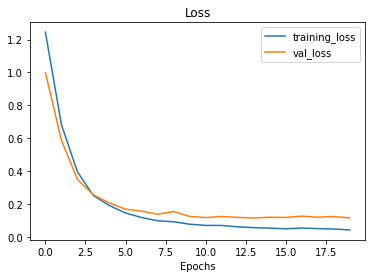

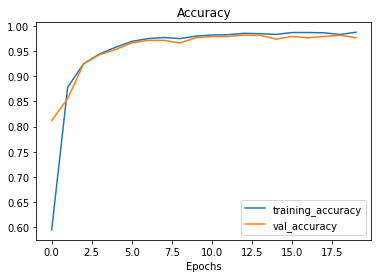

In [ ]:
plot_loss_curves(history)

In [ ]:
model_multi.evaluate(X_val, y_val)

13/13 [==============================] - 0s 3ms/step - loss: 0.1142 - accuracy: 0.9768


[0.11424027383327484, 0.9768041372299194]

In [ ]:
######### Evaluate the  Model ########
loss, accuracy = model_multi.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9846


In [ ]:
# Save the Model
model_multi.save("sign_classifier.h5")

In [ ]:
pred_probs = model_multi.predict(X_test)
pred_probs[:10]

array([[9.9957031e-01, 8.5415612e-09, 1.9759766e-06, 3.6872461e-04,
        5.8986850e-05],
       [3.6816502e-06, 3.2406897e-04, 9.9953794e-01, 1.3258911e-04,
        1.6182254e-06],
       [1.2858431e-03, 5.1377708e-04, 9.8921239e-01, 6.2299385e-03,
        2.7581432e-03],
       [2.9393747e-03, 3.4477869e-06, 6.1354049e-06, 9.9704212e-01,
        8.9122286e-06],
       [9.3589145e-09, 1.2249674e-03, 9.9874014e-01, 3.4737208e-05,
        7.4331851e-08],
       [1.8689088e-09, 9.9859411e-01, 7.8541529e-04, 6.1936764e-04,
        1.1023436e-06],
       [9.9912089e-01, 2.1216316e-08, 9.7465818e-07, 8.0031640e-04,
        7.7727054e-05],
       [1.6012135e-06, 1.2266819e-04, 8.6032719e-07, 9.9987292e-01,
        1.9213353e-06],
       [6.0770060e-05, 1.6763404e-05, 9.8343235e-06, 9.9990153e-01,
        1.1092208e-05],
       [1.0305130e-09, 9.9774015e-01, 8.3609571e-04, 1.4222983e-03,
        1.4344414e-06]], dtype=float32)

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 2, 2, 3, 2, 1, 0, 3, 3, 1])

In [ ]:
y_test[:10]

array([0, 2, 2, 3, 2, 1, 0, 3, 3, 1])

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_test, pred_classes)
sklearn_accuracy

0.9845758354755784

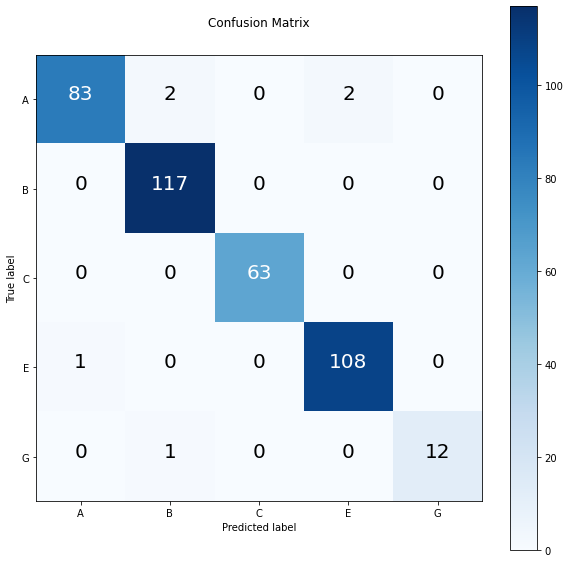

In [ ]:
# Plot a confusion matrix with all 17400 predictions, ground truth labels and 29 classes
make_confusion_matrix(y_true=y_test,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        87
           1       0.97      1.00      0.99       117
           2       1.00      1.00      1.00        63
           3       0.98      0.99      0.99       109
           4       1.00      0.92      0.96        13

    accuracy                           0.98       389
   macro avg       0.99      0.97      0.98       389
weighted avg       0.98      0.98      0.98       389



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_test, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9707602339181286,
  'precision': 0.9880952380952381,
  'recall': 0.9540229885057471,
  'support': 87},
 '1': {'f1-score': 0.9873417721518987,
  'precision': 0.975,
  'recall': 1.0,
  'support': 117},
 '2': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 63},
 '3': {'f1-score': 0.9863013698630138,
  'precision': 0.9818181818181818,
  'recall': 0.9908256880733946,
  'support': 109},
 '4': {'f1-score': 0.9600000000000001,
  'precision': 1.0,
  'recall': 0.9230769230769231,
  'support': 13},
 'accuracy': 0.9845758354755784,
 'macro avg': {'f1-score': 0.9808806751866083,
  'precision': 0.9889826839826841,
  'recall': 0.973585119931213,
  'support': 389},
 'weighted avg': {'f1-score': 0.9844780899941333,
  'precision': 0.9847235669215103,
  'recall': 0.9845758354755784,
  'support': 389}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'A': 0.9707602339181286,
 'B': 0.9873417721518987,
 'C': 1.0,
 'E': 0.9863013698630138,
 'G': 0.9600000000000001}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
2,C,1.000000
1,B,0.987342
3,E,0.986301
0,A,0.970760
4,G,0.960000


Now we're talking! Let's finish it off with a nice horizontal bar chart.



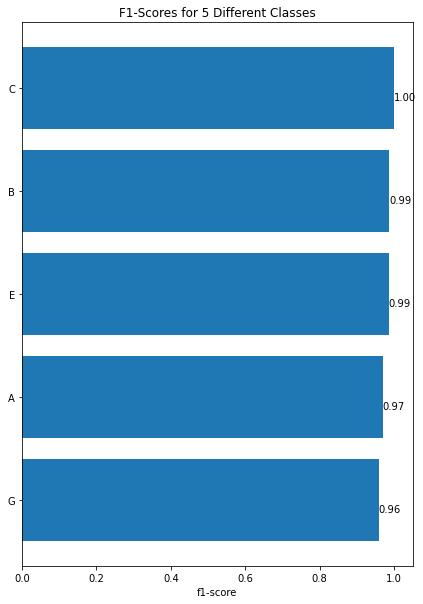

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 5 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)